In [1]:
import pandas as pd
import numpy as np
import control
from pprint import pprint

import sys
sys.path.append('../')
from control_utils import *
from IPython.display import display, Markdown, Latex, Image

Obteve-se a função de transferência do sistema contínuo de segunda ordem a partir do ensaio experimental e das equações dadas, obtendo-se $\zeta=0.3663105521206569$ e $w_n=175.8472962110833$, portanto $G(s)=$

$$\frac{3.092 \times 10^{4}}{s^2 + 128.8 s + 3.092 \times 10^{4}}$$

Pode-se perceber pela simulação do sistema que este é similar à planta real dada.

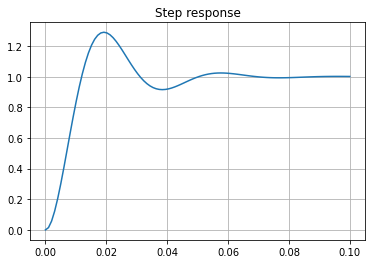

In [2]:
tfinal=0.09

# Experimental measurements
tp = 19.20e-3 #s
d2 = 496e-3 #V
d1 = 144e-3 #V

# Calculated metrics
Mp = d1/d2
zeta, wn = parameters_from_metrics(Mp=Mp, tp=tp)

# System's transfer function
G = system_from_parameters(zeta, wn)
display(Markdown(f'Obteve-se a função de transferência do sistema contínuo de segunda ordem a partir do ensaio experimental e das equações dadas, obtendo-se $\zeta={zeta}$ e $w_n={wn}$, portanto $G(s)=$'))
display(Markdown(G._repr_latex_()))
display(Markdown(f'Pode-se perceber pela simulação do sistema que este é similar à planta real dada.'))
x, y = control.step_response(G,0.1)
plt.plot(x,y)
plt.title('Step response')
plt.grid()

ts5 desejado (original): 33 ms
ts5 desejado (com margem): 32 ms
Mp desejado (original): 16 %
Mp desejado (com margem): 15 %


{'Mp': 15.018926706864146,
 'tp': 0.020232,
 'ts5': 0.029205000000000002,
 'ts2': 0.043218,
 'tr': 0.009216,
 'td': 0.0072,
 'ess': 0.00016456091042893473,
 'final_value_step_simulated': 0.9998354390895711,
 'final_value_step_theoretical': 0.9943016138492949}

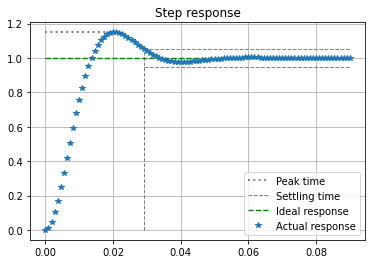

In [3]:
# Requirements
name = 'Leonardo Santiago Benitez Pereira'
l = len(name)

desired_ts5_original = len(name)
print(f'ts5 desejado (original): {desired_ts5_original} ms')
desired_ts5 = desired_ts5_original - 1 #margem de segurança
print(f'ts5 desejado (com margem): {desired_ts5} ms')
desired_ts5 = desired_ts5/1000
desired_Mp_original = 2*len(name.split()[0])
print(f'Mp desejado (original): {desired_Mp_original} %')
desired_Mp = desired_Mp_original - 1 #margem de segurança
print(f'Mp desejado (com margem): {desired_Mp} %')
desired_Mp = desired_Mp/100

desired_zeta, desired_wn = parameters_from_metrics(Mp=desired_Mp, ts5=desired_ts5)
desired_wd = desired_wn*np.sqrt(1-desired_zeta**2)
desired_G = system_from_parameters(desired_zeta, desired_wn)
metrics = step_info(desired_G, tfinal, plot=True)
metrics

In [4]:
#escolha do perído de amostragem
# 15 vezes 
T = int(1000*desired_ts5/6)/1000
print(f'O período de amostragem foi escolhido como sendo T={T*1000}ms, 10 vezes menor do que o tempo de subida desejado ts5={desired_ts5}s')

O período de amostragem foi escolhido como sendo T=5.0ms, 10 vezes menor do que o tempo de subida desejado ts5=0.032s


# Projeto de controlador digital no plano z pelo método do lugar das raízes
Escolheu-se primeiramente um ponto $z_1$ que deveria ser um polo dominante de malha fechada:
<img src="Images - relatório/image-20210721213424486.png"/>

Considerado o controlador da equação abaixo, é possível determinar $\alpha_1$ e $alpha_2$ de forma a cancelarem os polos do bloco $G(z)$ e então determinar $\beta$ de forma a satisfazer as condições de módulo ($\left|C(z)G(z)\right|_{z=z1} = 1$) e ângulo ($\angle C(z)G(z)_{z=z1} = 180º$)

$$
C(z) = \frac{z^2 + \alpha_1 + \alpha_2}{z^2 + (\beta-1)z -\beta}
$$

In [5]:
Gz = control.c2d(G,T);

In [6]:
ws = 2*np.pi/T
print(f'wd = {desired_wd}')
print('ws/wd é %.2f (deve ser maior que 8)'%(ws/desired_wd))

# Polo que satisfaz os parâmetros desejados
z1_abs = np.exp(-(2*np.pi*desired_zeta*desired_wd)/(np.sqrt(1-desired_zeta**2)*ws)) #TODO: na~o deveria ser desired wd?
z1_angle = T*desired_wd
z1 = z1_abs*np.exp(z1_angle*1j)
print('O polo desejado é z1 =', z1)

wd = 155.24812010862868
ws/wd é 8.09 (deve ser maior que 8)
O polo desejado é z1 = (0.4465296921706296+0.43842543343971496j)


In [7]:
#G1z = control.tf([1], [1, beta])
G2z = control.minreal(control.tf(Gz.num[0][0], [1, -1],T));
[[n2]],[[d2]] = control.tfdata(G2z);


# fi2 é o ângulo de G2z quando z=z1
fi2 = np.angle(np.polyval(n2,z1)/np.polyval(d2,z1));

# fi1 é o ângulo de G1z quando z=z1
fi1 = -np.pi-fi2;


beta = (np.imag(z1)-np.real(z1)*np.tan(-fi1))/np.tan(-fi1); # Pela condição de angulo
print(f'beta = {beta}')
Cz = control.tf(Gz.den[0][0], [1, beta-1, -beta], T) # Este tipo de compensador pode ser usado quando a planta possui polos complexos
print('o controlador deve fornecer', (np.pi - np.angle(Gz(z1)))*180/np.pi, 'graus')
print('O controlador calculado fornece', np.angle(Cz(z1))*180/np.pi, 'graus')

K = 1/abs((Cz*Gz)(z1)) # Pela condição de módulo
print(f'K = {K}')
Cz = K*Cz
display(Markdown('$\\angle C(z)G(z)_{z=z1} = %.2f ^º$'%(np.angle((Cz*Gz)(z1))*180/np.pi)))
display(Markdown('$\\left|C(z)G(z)\\right|_{z=z1} = %.2f$'%(np.abs((Cz*Gz)(z1)))))

FTMAz = Cz*Gz
FTMFz = control.feedback(FTMAz, 1)
FTMFz = control.minreal(FTMFz)
FTMFz

0 states have been removed from the model
beta = -0.16960573839324194
o controlador deve fornecer 135.19274048137805 graus
O controlador calculado fornece 135.19274048137805 graus
K = 0.9329312977855644


$\angle C(z)G(z)_{z=z1} = 180.00 ^º$

$\left|C(z)G(z)\right|_{z=z1} = 1.00$

2 states have been removed from the model


TransferFunction(array([0.27654635, 0.22199989]), array([ 1.        , -0.89305938,  0.39160563]), 0.005)


Metrics:
{'Mp': 14.990078233405669,
 'ess': 0.00017049217141418271,
 'final_value_step_simulated': 0.9998295078285858,
 'final_value_step_theoretical': 0.999999999999993,
 'td': 0.01,
 'tp': 0.02,
 'tr': 0.01,
 'ts2': 0.04,
 'ts5': 0.025}

Errors:
3 states have been removed from the model
3 states have been removed from the model
System type: 1
Error analysis:
{
    "Kp": 1279822466364175.8,
    "ess_degrau": 7.813583729631508e-16,
    "ess_degrau_theorem": -4.231149625972078e-15,
    "Kv": 120.07458755095146,
    "ess_rampa": 0.008328156859799067,
    "ess_rampa_theorem": 0.008328156859799016,
    "Ka": 0,
    "ess_parabola": Infinity,
    "ess_parabola_theorem": 0
}
{'Ka': 0,
 'Kp': 1279822466364175.8,
 'Kv': 120.07458755095146,
 'ess_degrau': 7.813583729631508e-16,
 'ess_degrau_theorem': -4.231149625972078e-15,
 'ess_parabola': inf,
 'ess_parabola_theorem': 0,
 'ess_rampa': 0.008328156859799067,
 'ess_rampa_theorem': 0.008328156859799016}


/src/Exercícios Controle 2/projeto 1/../control_utils.py:171: RuntimeWarning: divide by zero encountered in true_divide
  metrics['ess_parabola'] = np.array(1)/K


O sistema calculado atende todos os requisitos do protejo, conforme vê ne comparação:

Metric Desired     Actual
0  ts5 (ms)      33       25.0
1    Mp (%)      16  14.990078
2   ess (V)       0    0.00017
3    stable    True       True

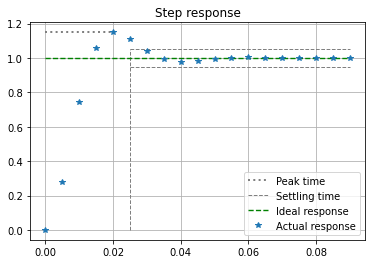

In [8]:
# Checking if requirements are met
print('\nMetrics:')
metrics = step_info(FTMFz, tfinal, plot=True) 
pprint(metrics) #calcula ess por simulação

print('\nErrors:')
e = errors(FTMA=Cz*Gz) #calcula ess pelo teorema do valor final
pprint(e)

assert metrics['ts5'] < desired_ts5_original/1000
assert metrics['Mp'] < desired_Mp_original
assert metrics['ess'] < 0.001
assert e['ess_degrau'] < 0.001

display(Markdown('O sistema calculado atende todos os requisitos do protejo, conforme vê ne comparação:'))
pd.DataFrame([
    ['ts5 (ms)', desired_ts5_original, metrics['ts5']*1000],
    ['Mp (%)', desired_Mp_original, metrics['Mp']],
    ['ess (V)', 0, metrics['ess']],
    ['stable', True, metrics['ess']<1]
], columns=['Metric', 'Desired', 'Actual'])

In [9]:
display(Markdown('## Funções no domínio z'))
display(Markdown('$G(z)$ = ' + Gz._repr_latex_()))
display(Markdown('-------------'))
display(Markdown('$C(z)$ = ' + Cz._repr_latex_()))

display(Markdown('Pode-se aplicar a transformada z inversa para obter as equações recursivas que implementam cada bloco separadamente, conforme segue:'))
display(Markdown('$$' + tf_reqeq_format(Gz) + '$$'))
display(Markdown('$$' + tf_reqeq_format(Cz, 'erro', 'u') + '$$'))

## Funções no domínio z

$G(z)$ = $$\frac{0.2964 z + 0.238}{z^2 - 0.9907 z + 0.5251}\quad dt = 0.005$$

-------------

$C(z)$ = $$\frac{0.9329 z^2 - 0.9243 z + 0.4899}{z^2 - 1.17 z + 0.1696}\quad dt = 0.005$$

Pode-se aplicar a transformada z inversa para obter as equações recursivas que implementam cada bloco separadamente, conforme segue:

$$y_{[n]} = +0.2964 u_{[n-1]} +0.238 u_{[n-2]} +0.9907y_{[n-1]} -0.5251y_{[n-2]}$$

$$u_{[n]} = +0.9329 erro_{[n+0]} -0.9243 erro_{[n-1]} +0.4899 erro_{[n-2]} +1.17u_{[n-1]} -0.1696u_{[n-2]}$$

Text(0, 0.5, 'Amplitude')

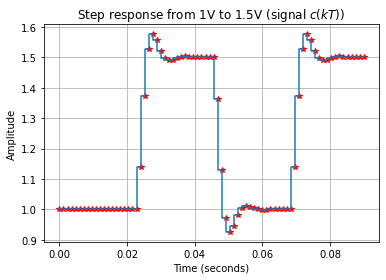

In [10]:
k_max = (int(np.ceil(tfinal/T)) + 1)*4
t = np.linspace(0, tfinal, k_max)

ref = np.concatenate((np.ones(int(k_max/4)), 1.5*np.ones(int(k_max/4)), np.ones(int(k_max/4)), 1.5*np.ones(int(k_max/4))))
erro = np.zeros(k_max) # após somador 
u = np.zeros(k_max) # após C
y = np.zeros(k_max) # após G
    
    
# Unroll first iterations to get initial conditions
n=0
y[n] = 1
erro[n] = ref[n] - y[n] 
u[n] = 1

n=1
y[n] = 1
erro[n] = ref[n] - y[n] 
u[n] = 1


# Simulate system
for n in range(2, k_max):
    y[n] = 0.2964*u[n-1] + 0.238*u[n-2] + 0.9907*y[n-1] - 0.5251*y[n-2]
    erro[n] = ref[n] - y[n] 
    u[n] = 0.9329*erro[n] - 0.9243*erro[n-1] + 0.4899*erro[n-2] + 1.17*u[n-1] - 0.1696*u[n-2]
    
plt.plot(t,y, '*', color='red', label='Por equações recursivas')
plt.step(t,y)
plt.title('Step response from 1V to 1.5V (signal $c(kT)$)')


plt.grid()
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

# E) Sinal de atuação

Utilizando o sistema simulado na questão anterior, observou-se o sinal de atuação, o qual não deve ultrapassar os limites físicos do hardware de implementação (que ainda não foi definido)



O valor máximo do sinal de atuação é 1.51
O valor mínimo do sinal de atuação é 0.99
As altas tensões na saída do sinal podem ser um problema para a implementação em hardware, de forma que pode vir a ser necessário adaptar o projeto do controlador para facilitar a sua implementação.


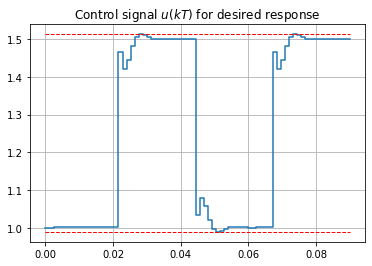

In [11]:
plot_control_signal(t, u, title='Control signal $u(kT)$ for desired response')
print('As altas tensões na saída do sinal podem ser um problema para a implementação em hardware, de forma que pode vir a ser necessário adaptar o projeto do controlador para facilitar a sua implementação.')